## United-atom, custom-element workflow with HOOMD and Freud
This workflow is designed to show users how to implement united-atom or coarse-grained particles into mbBuild and foyer. Additionally, we show how HOOMD and Freud can be used to conduct and analyze a molecular dynamics simulation

You will need hoomd, freud (at least 2.0), and gsd
```
conda install -c conda-forge hoomd freud gsd
```

In [1]:
import mbuild as mb
from foyer import Forcefield

In the general MoSDeF workflow, elements are attempted to be inferred from the names of `mb.Particle` objects
prior to atomtyping in foyer (as SMARTS definitions are generally based off element symbols).

However, united-atom or coarse-grained representations do not follow periodic elemental naming. To circumvent this,
we *add an underscore before each particle name*. When attempting to infer elements, no periodic elements can be inferred, and a **custom element** is created and applied to the particle. 

The follow mbuild code constructs various united-atom representations of CH4, CH3, and OH. 
*Note the underscore naming scheme*.

Methane compounds are a single particle, while a methanol compound is a two-particle compound conssiting of a CH3 bead and OH bead

In [2]:
methane_cmpd = mb.Compound()
methane_particle = mb.Particle(name="_CH4")
methane_cmpd.add(methane_particle)
methanol = mb.Compound()
ch3 = mb.Particle(name="_CH3")
oh = mb.Particle(name="_OH")
methanol.add([ch3, oh])

ch3_port = mb.Port(anchor=ch3, orientation=[1,0,0], separation=0.07)
methanol.add(ch3_port, label='right')

oh_port = mb.Port(anchor=oh, orientation=[-1,0,0], separation=0.07)
methanol.add(oh_port, label='left')

mb.force_overlap(move_this=oh,
                from_positions=methanol['left'],
                to_positions=methanol['right'])




To replicate these compounds, we utilize an `mb.Grid3DPattern`. Alternatively, one could use `mb.packing` functionality - however, `n_compounds` and `box` would likely have to be passed to `mb.fill_box`. If attempting to pass a `density` kwarg, the packing functionality will try to infer particle masses and can lead to some unpredictable behavior

In [3]:
methane_grid = mb.Grid3DPattern(2,2,2)
methane_grid.scale(0.4)
list_of_methanes = methane_grid.apply(methane_cmpd)
methane_box = mb.Compound(list_of_methanes)



In [4]:
methanol_grid = mb.Grid3DPattern(2,2,2)
methanol_grid.scale(0.4)
list_of_methanols = methane_grid.apply(methanol)
methanol_box = mb.Compound(list_of_methanols)

methanol_box.translate([0,0, 1.1*max(methane_box.xyz[:,2])])


In [5]:
mixture_box = mb.Compound([methane_box, methanol_box])


Now that we have initialized our united-atom system, we can proceed to use foyer to atomtype and parametrize our system. 

It is worth observing how the AtomType definitions, names, classes, and elements work together in a united-atom or coarse-grained application.

In [6]:
!head -n 16 ff.xml

<ForceField>
 <AtomTypes>
  <Type name="OH" class="OH" element="_OH" mass="15.99940" def="[_OH]" desc="Oxygen in hydroxyl" doi="10.1021/jp003882x"/>
  <Type name="CH4" class="CH4" element="_CH4" mass="16.04300" def="[_CH4]" desc="CH4, united atom" doi="10.1021/jp972543+"/>
  <Type name="CH3" class="CH3" element="_CH3" mass="15.03500" def="[_CH3;X1]_OH" desc="CH3, united atom, attached to hydroxyl" doi="10.1021/jp003882x"/>
 </AtomTypes>
 <HarmonicBondForce>
  <!-- CHX-OH -->
  <Bond class1="CH3" class2="OH" length="0.1430" k="502416.0"/>
   </HarmonicBondForce>
  <NonbondedForce coulomb14scale="0" lj14scale="0">
  <Atom type="OH" charge="-0.700" sigma="0.302" epsilon="0.773245"/>
  <Atom type="CH4" charge="0.0" sigma="0.373" epsilon="1.23054"/>
  <Atom type="CH3" charge="0.7" sigma="0.375" epsilon="0.814817"/>
 </NonbondedForce>
</ForceField>


In [7]:
ff = Forcefield(forcefield_files='ff.xml')
struc = ff.apply(mixture_box)

/Users/ayang41/Programs/foyer/foyer/forcefield.py:395: UserWarning: Non-atomistic element type detected. Creating custom element for _OH
  'Creating custom element for {}'.format(element))
/Users/ayang41/Programs/foyer/foyer/forcefield.py:395: UserWarning: Non-atomistic element type detected. Creating custom element for _CH4
  'Creating custom element for {}'.format(element))
/Users/ayang41/Programs/foyer/foyer/forcefield.py:395: UserWarning: Non-atomistic element type detected. Creating custom element for _CH3
  'Creating custom element for {}'.format(element))
/Users/ayang41/Programs/mbuild/mbuild/compound.py:2410: UserWarning: Guessing that "<_CH4 pos=( 0.0000, 0.0000, 0.0000), 0 bonds, id: 4744964808>" is element: "EP"
  atom, element))
/Users/ayang41/Programs/mbuild/mbuild/compound.py:2410: UserWarning: Guessing that "<_OH pos=( 0.1400, 0.0000, 0.2200), 0 bonds, id: 4744991744>" is element: "EP"
  atom, element))
/Users/ayang41/anaconda3/envs/py36/lib/python3.6/site-packages/parme

We will use the `gsd` file format as input to our HOOMD simulation

In [8]:
from mbuild.formats.gsdwriter import write_gsd
write_gsd(struc, 'box.gsd')

/Users/ayang41/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/core/numeric.py:2643: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


At this point, we have constructed, parametrized, and written-out our united-atom system. We will proceed to use HOOMD to conduct a molecular dynamics simulation

In [9]:
import hoomd
import hoomd.md
import hoomd.init

Even though we were able to parametrize an `mb.Compound` into a parametrized `pmd.Structure`, the parameters are not actually stored in the `gsd` file, only the lists of positions, atomtypes, bonds, angles, etc.

Within the HOOMD commands, we need to initialize the `hoomd.md.pair.LJ` and `hoomd.md.bond.harmonic` objects, which serve as a container for the various nonbonded and bonded parameters. 

The ability to pass parameters from a parametrized system to a HOOMD simulation is underway, but this can also be an exercise left to the user to systematically enumerate the relevant force field parameters in the simulation.

In [10]:
hoomd.context.initialize("")
system = hoomd.init.read_gsd('box.gsd')
nl = hoomd.md.nlist.cell()
lj = hoomd.md.pair.lj(3, nl)
lj.pair_coeff.set('CH4', 'CH4', sigma=0.373, epsilon=1.23054)
lj.pair_coeff.set('OH', 'OH', sigma=0.302, epsilon=0.773)
lj.pair_coeff.set('CH3','CH3', sigma=0.375, epsilon=0.815)

lj.pair_coeff.set('CH4', 'OH', sigma=0.3375, epsilon=0.975)
lj.pair_coeff.set('CH4', 'CH3', sigma=0.374, epsilon=1.001)
lj.pair_coeff.set('CH3', 'OH', sigma=0.3385, epsilon=0.7938)

bonds = hoomd.md.bond.harmonic()
bonds.bond_coeff.set('CH3-OH', k=502416, r0=0.1430)


HOOMD-blue v2.8.0-1-ga4de8f0a9 DOUBLE HPMC_MIXED SSE SSE2 SSE3 SSE4_1 
Compiled: 10/31/2019
Copyright (c) 2009-2019 The Regents of the University of Michigan.
-----
You are using HOOMD-blue. Please cite the following:
* J A Anderson, C D Lorenz, and A Travesset. "General purpose molecular dynamics
  simulations fully implemented on graphics processing units", Journal of
  Computational Physics 227 (2008) 5342--5359
* J Glaser, T D Nguyen, J A Anderson, P Liu, F Spiga, J A Millan, D C Morse, and
  S C Glotzer. "Strong scaling of general-purpose molecular dynamics simulations
  on GPUs", Computer Physics Communications 192 (2015) 97--107
-----
HOOMD-blue is running on the CPU
notice(2): Group "all" created containing 24 particles


We will run an NVT simulation and dump the trajectory to `traj.gsd`

In [11]:
all = hoomd.group.all()
hoomd.md.integrate.mode_standard(0.002)
hoomd.md.integrate.nvt(all, 10, 0.1)

dump = hoomd.dump.gsd('traj.gsd', 1000, group=all, overwrite=True)
hoomd.run(1e7)

notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 8
notice(2): Particles with 1 exclusions             : 16
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starting run **
Time 00:00:10 | Step 1788991 / 10000000 | TPS 178893 | ETA 00:00:45
Time 00:00:20 | Step 3521548 / 10000000 | TPS 173256 | ETA 00:00:37
Time 00:00:30 | Step 5834394 / 10000000 | TPS 231284 | ETA 00:00:18
Time 00:00:40 | Step 7366746 / 10000000 | TPS 153167 | ETA 00:00:17
Time 00:00:50 | Step 9152229 / 10000000 | TPS 178548 | ETA 00:00:04
Time 00:00:53 | Step 10000000 / 10000000 | TPS 217517 | ETA 00:00:00
Average TPS: 185517
---------
-- Neighborlist stats:
178763 normal updates / 100000 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 7 / n_neigh_avg: 3
shortest rebuild period: 2
-- Cell list stats:
Dimension: 2, 2, 2
n_min    : 0 / n_max: 7 / n_avg: 3
** run complete **


After conducting the HOOMD simulation, we will use `freud`, `gsd`, and `numpy` to analyze the simulation, looking at various RDFs

In [12]:
import freud
import gsd
import gsd.fl, gsd.hoomd
import numpy as np

We can read in the `gsd` file and construct a `HOOMDTrajectory` object from it.

In [13]:
f = gsd.fl.GSDFile('traj.gsd', 'rb')

In [14]:
hoomd_traj = gsd.hoomd.HOOMDTrajectory(f)

Initialize the freud RDF analysis objects

In [15]:
bins = 50
r_max =2
ch3_ch3_rdf = freud.density.RDF(bins, r_max)
ch4_ch4_rdf = freud.density.RDF(bins, r_max)
oh_oh_rdf = freud.density.RDF(bins, r_max)

ch3_ch4_rdf = freud.density.RDF(bins, r_max)
ch3_oh_rdf = freud.density.RDF(bins, r_max)
ch4_oh_rdf = freud.density.RDF(bins, r_max)

Iterating through each frame in the `HOOMDTrajectory`, identify the various types of particles, then compute and accumulate the various particle-particle RDFs

In [16]:
for frame in hoomd_traj:
    ch3_particles = [i for i,val in enumerate(frame.particles.typeid) if 
                frame.particles.types[val]=='CH3']
    ch4_particles = [i for i,val in enumerate(frame.particles.typeid) if
                frame.particles.types[val]=='CH4']
    oh_particles = [i for i,val in enumerate(frame.particles.typeid) if
                frame.particles.types[val]=='OH']
    
    ch3_positions = np.array(frame.particles.position[ch3_particles])
    ch4_positions = np.array(frame.particles.position[ch4_particles])
    oh_positions = np.array(frame.particles.position[oh_particles])

    ch3_ch3_rdf.compute(frame, query_points=ch3_positions, reset=False)
    ch4_ch4_rdf.compute(frame, query_points=ch4_positions, reset=False)
    oh_oh_rdf.compute(frame, query_points=oh_positions, reset=False)

                   

We can use `matplotlib` to plot the simulated RDFs and compare to the reference RDFs.

Note: because the simulation is so short and small, the RDFs will have noise and some disagreement.

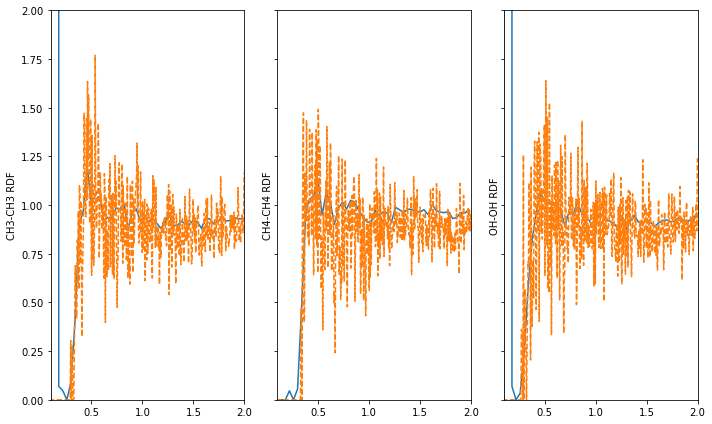

In [18]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,3, figsize=(10,6), sharex=True, sharey=True)

ax[0].plot(ch3_ch3_rdf.bin_centers, ch3_ch3_rdf.rdf)
ref_ch3_ch3 = np.loadtxt('ref/CH3-CH3.dat')
ax[0].plot(ref_ch3_ch3[:,0], ref_ch3_ch3[:,1], linestyle='--')
ax[0].set_ylabel("CH3-CH3 RDF")
ax[0].set_xlim([0.1, 2])
ax[0].set_ylim([0,2])

ax[1].plot(ch4_ch4_rdf.bin_centers, ch4_ch4_rdf.rdf)
ref_ch4_ch4 = np.loadtxt('ref/CH4-CH4.dat')
ax[1].plot(ref_ch4_ch4[:,0], ref_ch4_ch4[:,1], linestyle='--')
ax[1].set_ylabel("CH4-CH4 RDF")

ax[2].plot(oh_oh_rdf.bin_centers, oh_oh_rdf.rdf)
ref_oh_oh = np.loadtxt('ref/OH-OH.dat')
ax[2].plot(ref_oh_oh[:,0], ref_oh_oh[:,1], linestyle='--')
ax[2].set_ylabel("OH-OH RDF")

fig.tight_layout()